# 🤗 Multimodal generation - Part 3: unsupervised linear representation mapping using PCA 🤗

In [1]:
cd ..

/Users/simonbrandeis/dev/multimodal-code-exercise


## Approach

We want to map sequences of elements in $R^{768}$ (BERT hidden states) to elements in $R^{128}$ (BigGAN embeddings).

The general process to accomplish such a task could be splitted in a few steps:
- Pool the sequence
- Reduce the dimensionality from 768 to 128
- Align the representation

The order in which these steps are performed can vary.

This first model is very simple. It is composed of:

- A simple BERT pooler layer, that take the first hidden state of each sequence. This hidden state corresponds to the embedding of the `[CLS]` token, and is believed to be a "summary" of the input sentence
- A linear layer for reducing the dimension, performing a PCA and a projection on the 128 first principal components
- A linear layer performing a rotation to align both representations

The advantages of such model is that it does require gradient descent to optimize its parameters: finding both the PCA components and the rotation matrix (cf the [orthognal Procrustes problem](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.orthogonal_procrustes.html)) can be done via a singular value decomposition.

# Implementation

In [2]:
import os
import numpy as np
import torch
import transformers
from torch import nn
from transformers import AutoTokenizer, AutoModel
from pytorch_pretrained_biggan import BigGAN

In [3]:
from sklearn.decomposition import PCA
from numpy.linalg import svd
from scipy.linalg import orthogonal_procrustes

## Parameter definition

In [4]:
DATA_DIR="./data/"
MODELS_DIR="./models/"
PRETRAINED_LM_NAME = 'distilbert-base-uncased'
PRETRAINED_GAN_NAME = 'biggan-deep-128'
SEED=42

## Load the data

In [5]:
labels_representations_tensor = torch.load(os.path.join(DATA_DIR, "labels_representations_tensor.bin"))
text_representations_tensor = torch.load(os.path.join(DATA_DIR, "text_representations_tensor.bin"))

## Prepare the data for learning

In [6]:
source_data = text_representations_tensor.detach().numpy()[:, 0, :]  # CLS token
target_data = labels_representations_tensor.detach().numpy()
_, source_dim = source_data.shape
_, target_dim = target_data.shape

# Learn - Step 1: PCA

In [7]:
# PCA
pca = PCA(n_components=target_dim)
projection = pca.fit_transform(source_data)
pca_mean, pca_components = pca.mean_, pca.components_

pca_layer = nn.Linear(in_features=source_dim, out_features=target_dim)
with torch.no_grad():
    pca_layer.weight.data = torch.FloatTensor(pca_components)
    pca_layer.bias.data = torch.FloatTensor(- pca_mean @ pca_components.T)

## Learn - Step 2: Rotation matrix via the orthogonal Procrustes problem

In [8]:
# Rotation - Procrustes
target_mean = target_data.mean(axis=0)
rotation_matrix, scale = orthogonal_procrustes(projection, target_data - target_mean)

rotation_layer = nn.Linear(in_features=target_dim, out_features=target_dim, bias=True)
with torch.no_grad():
    rotation_layer.weight.data = torch.FloatTensor(rotation_matrix.T)
    rotation_layer.bias.data = torch.FloatTensor(target_mean)

## Instantiate and save the model

In [9]:
from text2img.models.utils import BertSimplePooler

simple_pooler = BertSimplePooler()

representation_mapping = nn.Sequential(simple_pooler, pca_layer, rotation_layer)

torch.save(representation_mapping, os.path.join(MODELS_DIR, "pca_procrustes_model.pth"))

## Demonstration

### Load the pretrained language models and GAN

In [10]:
lm_model = AutoModel.from_pretrained(PRETRAINED_LM_NAME)
lm_tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_LM_NAME)
gan_model = BigGAN.from_pretrained(PRETRAINED_GAN_NAME)

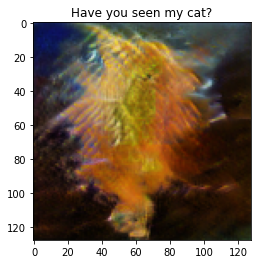

In [11]:
from run_model import generate_image, print_image, text_to_image

INPUT_TEXT = "Have you seen my cat?"

text_to_image(
    text=INPUT_TEXT,
    lm_model=lm_model,
    lm_tokenizer=lm_tokenizer,
    gan_model=gan_model,
    mapping_model=representation_mapping,

)

# Comments and possible improvements

Qualitatively, the model is very unsatisfactory (at least for the initial purpose: generating realistic images from an arbitrary text input).

Not only the generated images are completely unrelated to the input text, but they do not even look like real images.

A few points that can explain such a disapointing performance:
- The whole process is linear, making it unable to learn non-linear relationships between the source and target representations
- PCA is certainly not the appropriate way to reduce the dimensionality here. Since the PCA process only "knows" the text representation data, we have no guarantee that the kept dimensions are relevant for the task and can be aligned on the ImageNet classes representations' ones.

A few leads to improve the model:
- Use another dimensionality reducer that takes into account the ImageNet classes representations (learn the model end to end)
- Add some non-linearity.